<a href="https://colab.research.google.com/github/custom-hyper/Analytics/blob/main/Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Infra

Change Requests:
* Remove zeros of market capitalization
* Combine with other tables that don't often update but are useful for research

In [1]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#@title pip 
!pip install pytrends --quiet
!pip install pycoingecko --quiet
!pip install pandas --quiet
!pip install requests --quiet
!pip install pipreqs --quiet
!pip install configparser --quiet
!pip install psycopg2-binary==2.8.6 --quiet

!pip install matplotlib --quiet
!pip install mplfinance --quiet

     |████████████████████████████████| 3.0 MB 5.3 MB/s 
     |████████████████████████████████| 71 kB 3.3 MB/s 


In [3]:
#@title Ta-lib – Extra steps { display-mode: "code" }
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 124015 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.25-cp38-cp38-linux_x86_64.whl size=1820851 sha256=3d68c966fd4801f197083c4bb632aded7e51f24c69139ff0103d3

In [4]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import mplfinance as fplt
from datetime import datetime as dt
from datetime import timedelta
from datetime import date
import talib as ta
import time
import json
import seaborn as sns
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
#from __future__ import division

## Setup SQLite


In [5]:
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [6]:
#@title   Show Available Tables { display-mode: "code" }
cursor = conn_SQLite.cursor()

%time
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#cursor.execute("DROP TABLE 'proprietary_Twitter_Partnership_ohlc';")
cursor.fetchall()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


[('deFi_lama_total_TVL',),
 ('proprietary_Twitter_Partnership_ohlc',),
 ('proprietary_master_id',),
 ('CoinGecko_ohlc',),
 ('proprietary_tweets_extract',),
 ('proprietary_Twitter_partnerships_announcements',),
 ('proprietary_dashboard',),
 ('watchlist_CoinGecko_ohlc',),
 ('deFi_lama_tvl',),
 ('testing',),
 ('proprietary_airtable_watch_all',),
 ('deFi_lama_general',),
 ('proprietary_Twitter_id',),
 ('CoinGecko_main',),
 ('cal_mvp',),
 ('proprietary_economic_announcement',),
 ('ftx_subaccount_nickname',),
 ('ftx_subaccount_balances',),
 ('ftx_account',),
 ('ftx_positions',),
 ('ftx_wallet_coins',),
 ('ftx_wallet_deposits',),
 ('ftx_wallet_withdrawals',),
 ('ftx_orders_history',),
 ('ftx_fills',),
 ('ftx_funding_payments',),
 ('ftx_balancess',),
 ('ftx_markets',),
 ('ftx_futures',),
 ('proprietary_screener s',),
 ('proprietary_watchlist_hist',),
 ('CoinGecko_markets',),
 ('proprietary_screener',),
 ('CoinGecko_categories',),
 ('CoinGecko_derivatives_exchange_list',),
 ('CoinGecko_derivati

# Extract Data

Data source: [CoinGecko API wrapper](https://github.com/man-c/pycoingecko)

In [7]:
#@title Main – Extract { display-mode: "code" }

frames = []
cg = CoinGeckoAPI()

try:

  start =  1
  ends = 140

  for i in tqdm(range(start,ends)):

    output = cg.get_coins_markets(vs_currency='usd', page = i)
    
    data = pd.json_normalize(output,max_level=4)
    frames.append(data)
    time.sleep(5)

except ConnectionError:
    time.sleep(60)

full_table = pd.concat(frames) #Careful, this line must be outside of the for loop

full_table['date'] = date.today()


  0%|          | 0/139 [00:00<?, ?it/s]

In [8]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13086 entries, 0 to 85
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                13086 non-null  object 
 1   symbol                            13086 non-null  object 
 2   name                              13086 non-null  object 
 3   image                             13086 non-null  object 
 4   current_price                     12672 non-null  float64
 5   market_cap                        12459 non-null  object 
 6   market_cap_rank                   3948 non-null   object 
 7   fully_diluted_valuation           5602 non-null   float64
 8   total_volume                      12688 non-null  float64
 9   high_24h                          8630 non-null   object 
 10  low_24h                           8630 non-null   object 
 11  price_change_24h                  8630 non-null   object 
 12  price_c

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7454b6b820>,
      dtype=object)

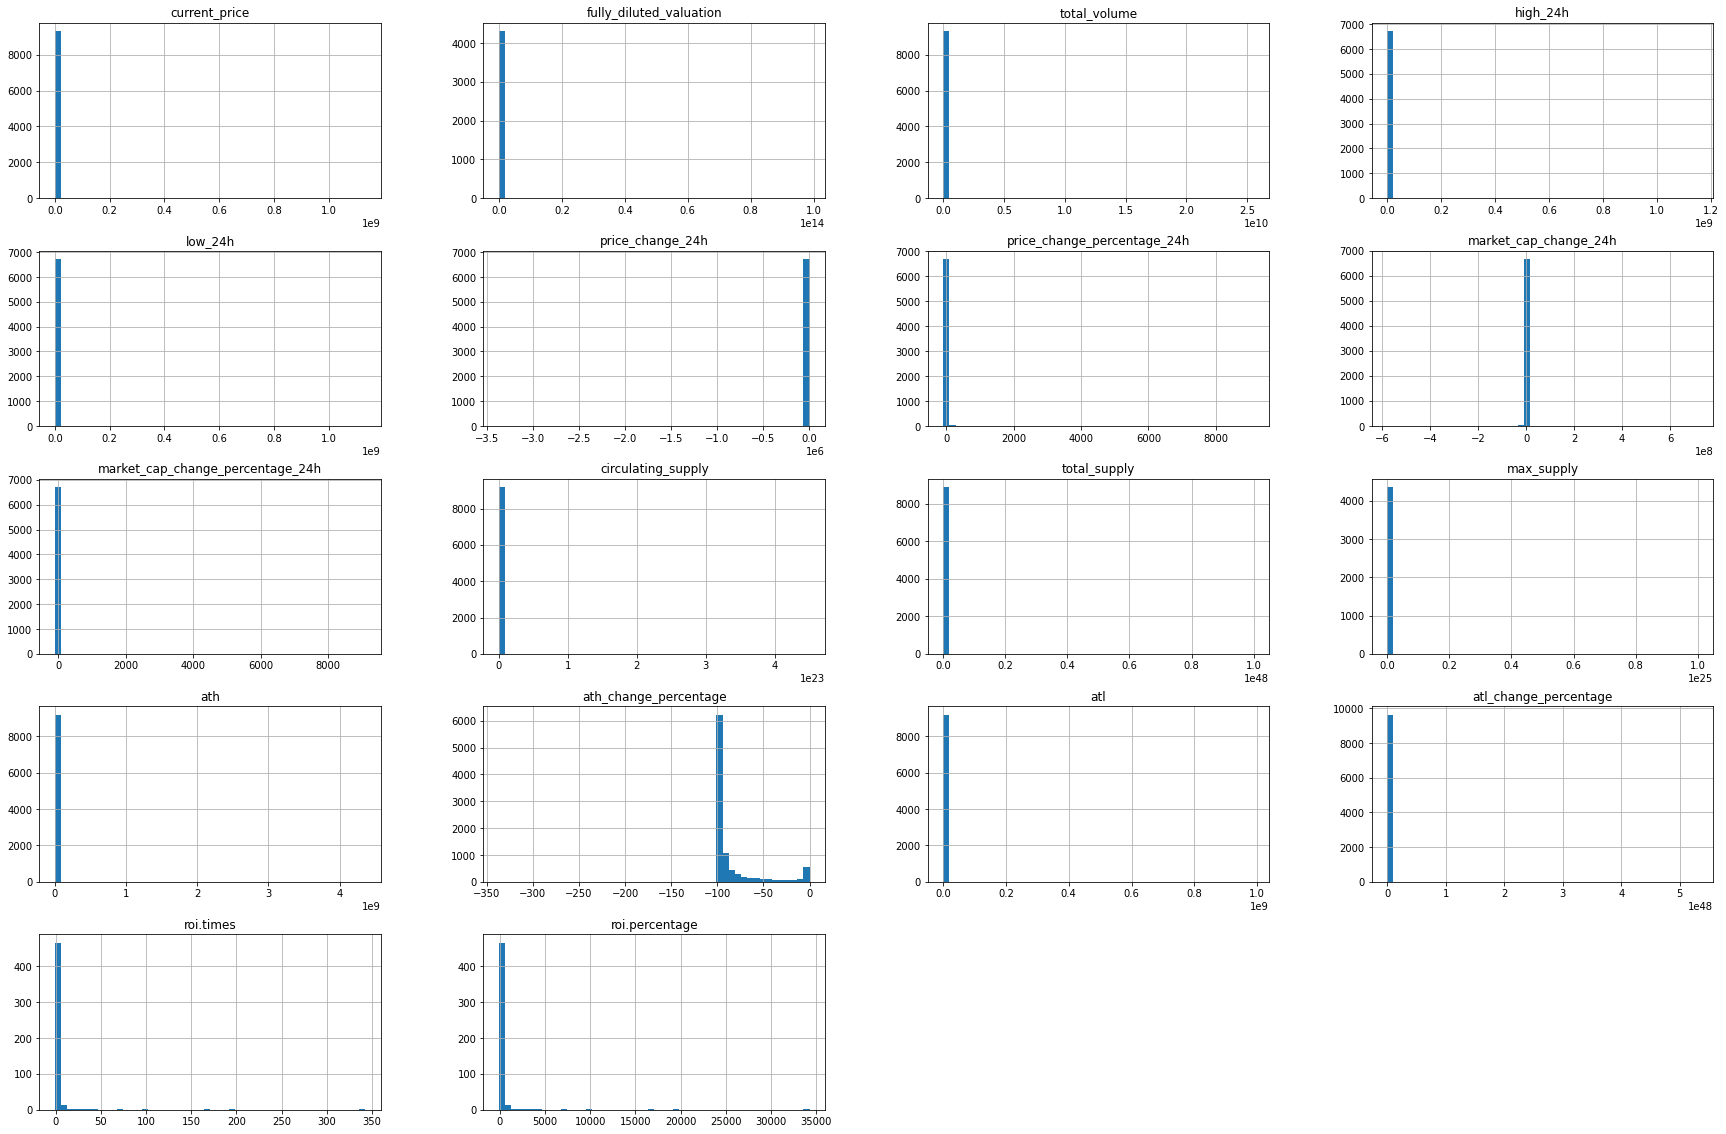

In [9]:
proprietary_screener = "CoinGecko_markets"

full_table.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

full_table = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

full_table.head()
full_table.hist(bins = 50,figsize = (30, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7454a70130>,
      dtype=object)

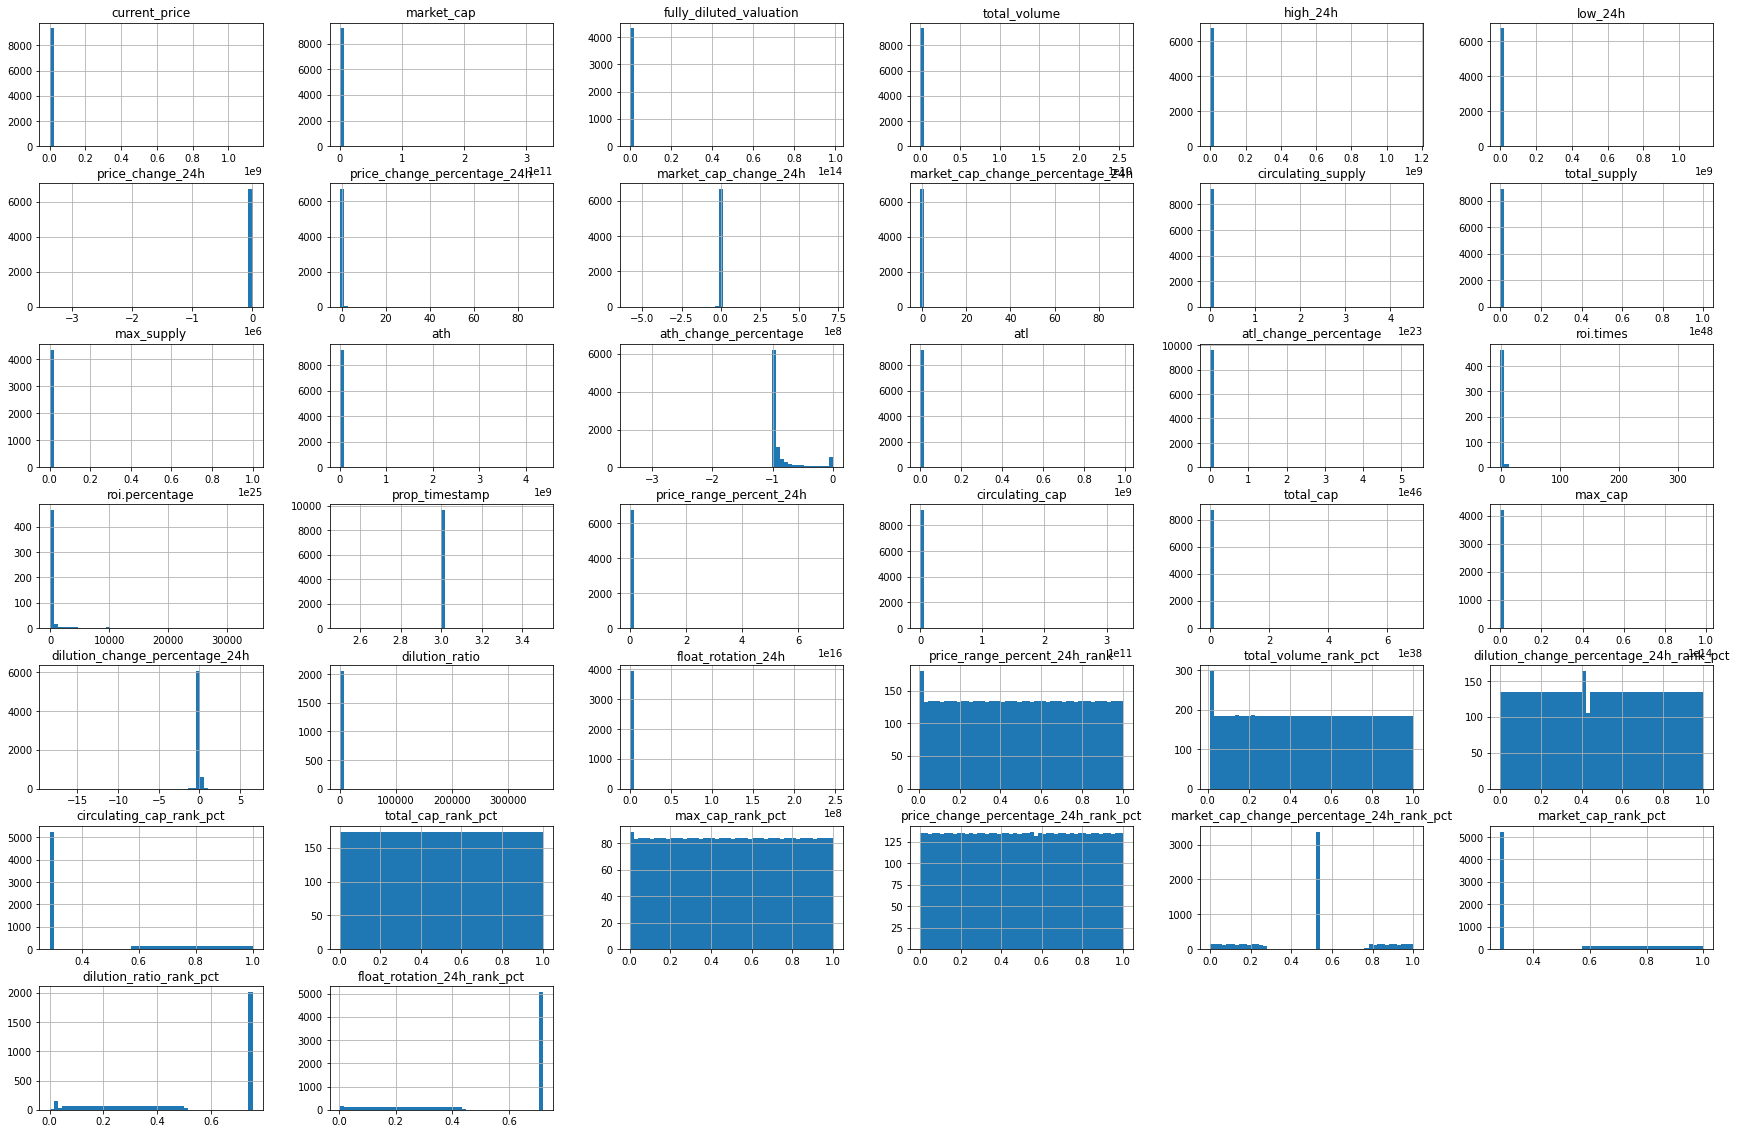

In [10]:
#@title Main – Wrangling{ display-mode: "code" }
#0 division function
def zero_div(x,y):

    try:
        return x/y
    except ZeroDivisionError:
        return 0


#Setting proper datatype/Time
full_table['market_cap'] = full_table['market_cap'].astype(float)
full_table['prop_timestamp'] = int( time.time_ns() / 1000 )
full_table['prop_timestamp'] = full_table['prop_timestamp'].astype(np.int8)

#Create custom features
full_table['price_range_percent_24h'] =  (full_table['high_24h'] - full_table['low_24h'] ) / 0.5*(full_table['high_24h'] + full_table['low_24h'] ) 
full_table['circulating_cap'] = full_table['current_price'] * full_table['circulating_supply']
full_table['total_cap'] = full_table['current_price'] * full_table['total_supply']
full_table['max_cap'] = full_table['current_price'] * full_table['max_supply']
full_table['price_change_percentage_24h'] = round(full_table['price_change_percentage_24h'], 5)/100
full_table['ath_change_percentage'] = full_table['ath_change_percentage']/100
full_table['market_cap_change_percentage_24h'] = full_table['market_cap_change_percentage_24h']/100
full_table['atl_change_percentage'] = full_table['atl_change_percentage']/100
full_table['dilution_change_percentage_24h'] = full_table['market_cap_change_percentage_24h'] - full_table['price_change_percentage_24h']
full_table['CoinGecko_link'] = str('https://www.coingecko.com/en/coins/') + full_table['id']
full_table['symbol'] = full_table['symbol'].str.upper()
full_table['dilution_ratio'] = zero_div(full_table['max_supply'],full_table['circulating_supply'])
full_table['float_rotation_24h'] = zero_div(full_table['total_volume'],full_table['market_cap'])


#Ranking
full_table['price_range_percent_24h_rank']  =  full_table['price_range_percent_24h'].rank(pct=True)
full_table['total_volume_rank_pct']  =  full_table['total_volume'].rank(pct=True)
full_table['dilution_change_percentage_24h_rank_pct'] = full_table['dilution_change_percentage_24h'].rank(pct=True)
full_table['circulating_cap_rank_pct'] = full_table['circulating_cap'].rank(pct=True)
full_table['total_cap_rank_pct'] = full_table['total_cap'].rank(pct=True)
full_table['max_cap_rank_pct'] = full_table['max_cap'].rank(pct=True)
full_table['price_change_percentage_24h_rank_pct'] = full_table['price_change_percentage_24h'].rank(pct=True)
full_table['market_cap_change_percentage_24h_rank_pct'] = full_table['market_cap_change_percentage_24h'].rank(pct=True)
full_table['market_cap_rank_pct'] = full_table['market_cap'].rank(pct=True)
full_table['dilution_ratio_rank_pct'] = full_table['dilution_ratio'].rank(pct=True)
full_table['float_rotation_24h_rank_pct'] = full_table['float_rotation_24h'].rank(pct=True)

#Date
full_table['date'] = date.today()

full_table.replace([np.inf, -np.inf], np.nan, inplace=True)
#np.set_printoptions(formatter={'float_kind':'{:f}'.format})
full_table
full_table.hist(bins = 50,figsize = (30, 20))


In [11]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9626 entries, 0 to 9625
Data columns (total 50 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         9626 non-null   object 
 1   symbol                                     9626 non-null   object 
 2   name                                       9626 non-null   object 
 3   image                                      9626 non-null   object 
 4   current_price                              9340 non-null   float64
 5   market_cap                                 9190 non-null   float64
 6   market_cap_rank                            3948 non-null   object 
 7   fully_diluted_valuation                    4321 non-null   float64
 8   total_volume                               9350 non-null   float64
 9   high_24h                                   6733 non-null   float64
 10  low_24h                 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7450cf4af0>,
      dtype=object)

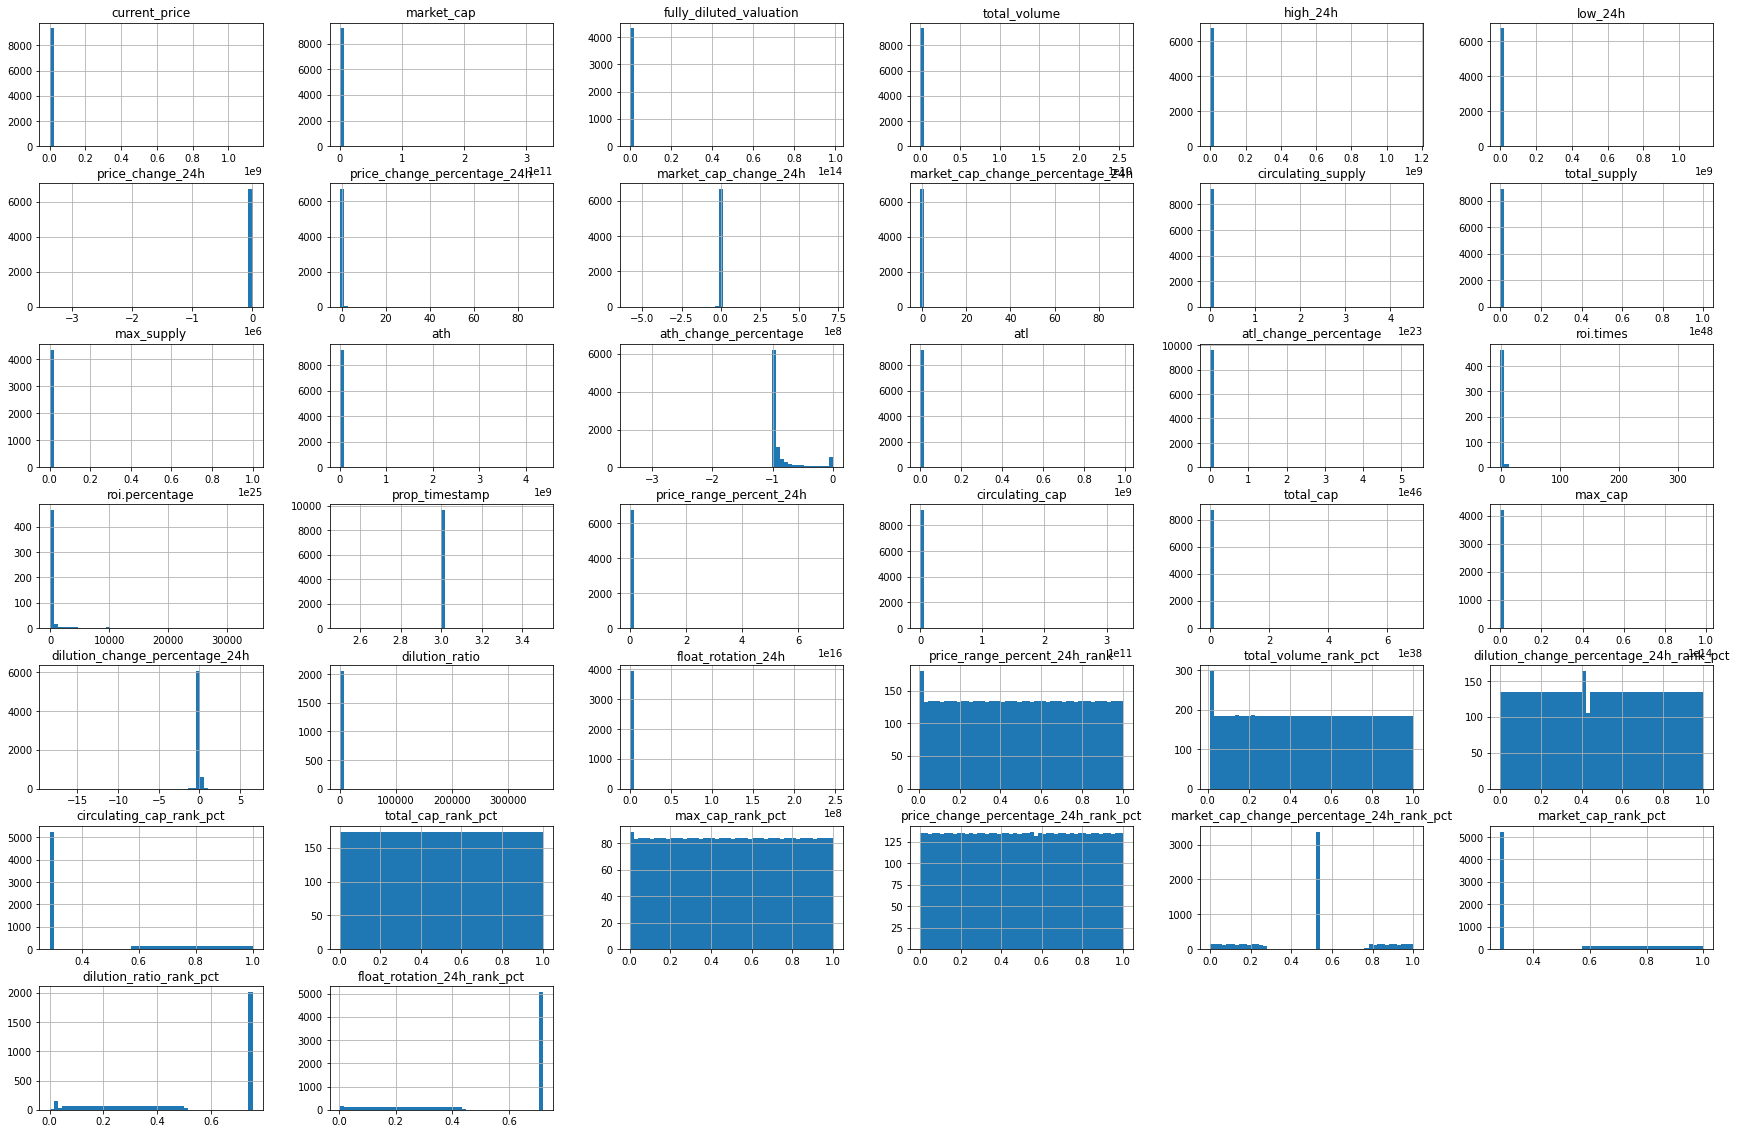

In [12]:

proprietary_screener = "proprietary_screener"

full_table.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

main = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

main.head()
main.hist(bins = 50,figsize = (30, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f744d2bb790>,
      dtype=object)

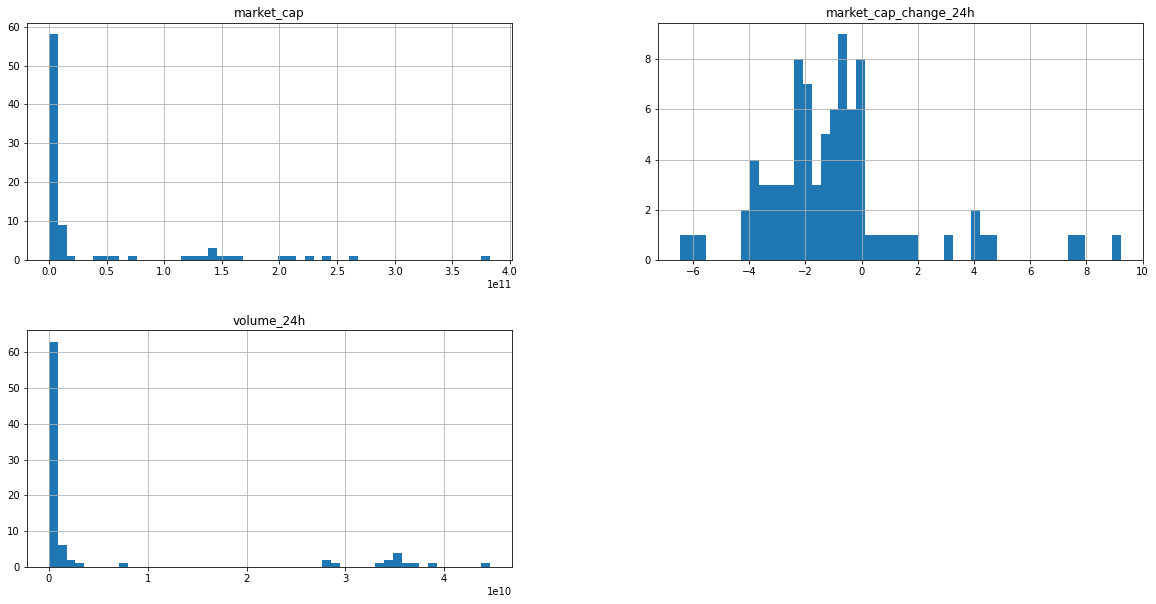

In [13]:
#@title Categories Data { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_coins_categories(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)
del data['top_3_coins']

CoinGecko_derivatives = "CoinGecko_categories"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 
Order by market_cap_change_24h	
""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.hist(bins = 50,figsize = (20, 10))





In [38]:
#@title Futures Product { display-mode: "code" }

cg = CoinGeckoAPI()

output = cg.get_derivatives(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)

data = pd.DataFrame(output, columns =(
    ['market', 'symbol', 'index_id', 'price', 'price_percentage_change_24h',
       'contract_type', 'index', 'basis', 'spread', 'funding_rate',
       'open_interest', 'volume_24h', 'last_traded_at', 'last_traded_at_f']))

data['last_traded_at_f'] = pd.to_datetime(data['last_traded_at'], unit='s')

Coin_derivatives = "CoinGecko_derivatives"

data.to_sql(Coin_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()





In [37]:
output = cg.get_derivatives_exchanges()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

#@title Futures Exchanges { display-mode: "code" }

CoinGecko_derivatives = "CoinGecko_derivatives_exchange_list"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)
CoinGecko_derivatives.head()


,name,id,open_interest_btc,trade_volume_24h_btc,number_of_perpetual_pairs,number_of_futures_pairs,image,year_established,country,description,url
0,Binance (Futures),binance_futures,420479.78,1409696.14,237,42,https://assets.coingecko.com/markets/images/46...,2019.0,None,,https://www.binance.com/
1,BTCEX (Futures),btcex_futures,273610.58,545323.93,84,0,https://assets.coingecko.com/markets/images/75...,NaN,None,,https://www.btcex.com/en-us/
2,BTCC Futures,btcc_futures,252348.00,348783.77,11,63,https://assets.coingecko.com/markets/images/84...,2011.0,None,,https://www.btcc.com/en-US/trade/
3,Bitget Futures,bitget_futures,223081.52,233942.51,108,0,https://assets.coingecko.com/markets/images/59...,NaN,None,,https://www.bitget.com/en/
4,Deepcoin (Derivatives),deepcoin_derivatives,212723.12,192745.75,83,0,https://assets.coingecko.com/markets/images/94...,2018.0,Singapore,,https://www.deepcoin.com/


# Generate Watchlist

In [42]:
#@title Futures { display-mode: "code" }

movers_derivatives = pd.read_sql("""
select *
from {} 
WHERE
price_percentage_change_24h > 15

OR
price_percentage_change_24h < -10
GROUP by symbol
""".format(Coin_derivatives), conn_SQLite)
movers_derivatives

,market,symbol,index_id,price,price_percentage_change_24h,contract_type,index,basis,spread,funding_rate,open_interest,volume_24h,last_traded_at,last_traded_at_f
0,BitMEX (Derivative),BMEXUSD,BBMEX,0.59,-11.624441,perpetual,0.593000,0.000000,0.84,0.010000,1.354201e+06,7.141649e+05,1670361620,2022-12-06 21:20:20
1,BitMEX (Derivative),BMEXUSDT,BBMEXT,0.59,-10.810811,perpetual,0.593000,-0.168350,0.50,-0.150800,4.625139e+08,1.416365e+06,1670361620,2022-12-06 21:20:20
2,HitBTC (Derivatives),CELUSDT_PERP,CEL,0.64,-29.913044,perpetual,0.684500,6.156948,3.87,0.010000,7.248100e+02,5.753281e+02,1670326767,2022-12-06 11:39:27
3,Huobi Futures,CTSI-USDT,CTSI,0.13,19.317161,perpetual,0.132951,0.113354,7.14,-1.500000,NaN,1.119961e+06,1670361570,2022-12-06 21:19:30
4,BTSE (Futures),CTSIPFC,CTSIPFC,0.13,19.202899,perpetual,0.133700,1.595745,0.90,0.000000,NaN,1.202889e+04,1670361571,2022-12-06 21:19:31
5,Crypto.com Exchange (Futures),CTSIUSD-PERP,CTSI,0.13,18.945383,perpetual,0.133080,0.506004,0.41,-0.005189,7.664288e+04,7.664288e+04,1670361598,2022-12-06 21:19:58
6,Bybit (Futures),CTSIUSDT,CTSI,0.13,19.506726,perpetual,0.134560,0.983114,0.08,-1.075000,3.695730e+06,2.405887e+07,1670360574,2022-12-06 21:02:54
7,KuCoin Futures,CTSIUSDTM,KCTSIUSDT,0.13,18.299776,perpetual,0.132800,0.453858,0.11,-0.827300,4.183718e+06,7.092348e+06,1670361580,2022-12-06 21:19:40
8,Gate.io (Futures),CTSI_USDT,CTSI,0.13,19.293478,perpetual,0.133167,1.113895,50.00,-0.540700,4.432771e+06,4.008129e+06,1670361584,2022-12-06 21:19:44
9,WOO Network (Futures),PERP_SUSHI_USDT,SUSHI,1.25,-10.616930,perpetual,1.246025,0.002006,0.16,-0.002199,3.226377e+04,7.165552e+05,1670361597,2022-12-06 21:19:57


In [34]:
#@title Futures { display-mode: "code" }

Coin_derivatives = pd.read_sql("""
select *
from {} 

Order by funding_rate DESC
""".format(Coin_derivatives), conn_SQLite)

Coin_derivatives

,market,symbol,index_id,price,price_percentage_change_24h,contract_type,index,basis,spread,funding_rate,open_interest,volume_24h,last_traded_at,last_traded_at_f
0,Kraken (Futures),PF_DEFIUSD,KrakenFutures-,229.42,-1.540706,perpetual,2.292100e+02,-0.091535,0.65,47223.232956,1254.93,7.570860e+01,1670352322,2022-12-06 18:45:22
1,Globe (Derivatives),ETH-PERP,ETH,1275.2,-1.147287,perpetual,1.253483e+03,-1.703027,0.32,11.000000,NaN,4.688966e+03,1670338967,2022-12-06 15:02:47
2,CoinEx (Futures),ELON-USDT,ELON,0.0,-0.780916,perpetual,3.489630e-07,-1.025024,0.59,0.750000,NaN,2.318411e+05,1670360525,2022-12-06 21:02:05
3,Globe (Derivatives),OP-PERP,OP,1.04,3.117269,perpetual,1.035499e+00,-0.623896,NaN,0.666667,NaN,3.187480e+05,1670357499,2022-12-06 20:11:39
4,BIT (Futures),USD-M:RSS3-USD-PERPETUAL,RSS3,0.12,0.708333,perpetual,1.216215e-01,0.638386,0.04,0.449999,NaN,2.119681e+06,1670360461,2022-12-06 21:01:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,Bybit (Futures),CTSIUSDT,CTSI,0.13,19.506726,perpetual,1.345600e-01,0.983114,0.08,-1.075000,3695729.89,2.405887e+07,1670360574,2022-12-06 21:02:54
3108,BTCEX (Futures),WEMIX-USDT-PERPETUAL,WEMIX,0.89,-5.740002,perpetual,8.911700e-01,-0.003366,0.13,-1.100000,3239777.80,1.819595e+06,1670360943,2022-12-06 21:09:03
3109,Globe (Derivatives),LDO-PERP,LDO,1.05,-1.071127,perpetual,1.063000e+00,0.959255,NaN,-1.333333,NaN,2.216900e+04,1670354819,2022-12-06 19:26:59
3110,Huobi Futures,CTSI-USDT,CTSI,0.13,19.676550,perpetual,1.347381e-01,1.154735,7.14,-1.500000,NaN,1.107359e+06,1670360998,2022-12-06 21:09:58



Reusable scripts

Short
```
WHERE
market_cap > 100000000
AND
dilution_ratio > 6;
```
Long
```
WHERE
price_change_percentage_24h > '2.0e-01'
AND
float_rotation_24h >  0.2
AN
dilution_ratio <  5
```

In [43]:
Watchlist_name ='Big Mover'

filter = """

-- Big positive mover
(
price_change_percentage_24h > 0.19
AND
total_volume > 500000
AND
float_rotation_24h >  0.1
)

OR
-- Big negative mover
(
price_change_percentage_24h < -0.09
AND
total_volume > 500000
AND
float_rotation_24h >  0.1
)
;
"""

In [44]:
#@title OHLC { display-mode: "code" }


proprietary_master_id  = "proprietary_screener"

df_main = pd.read_sql(
"""
SELECT
id,
symbol,
name,
market_cap,
total_volume,
price_change_percentage_24h,
float_rotation_24h,
dilution_ratio,
last_updated

FROM {}

WHERE {}
"""
.format(proprietary_master_id, filter), conn_SQLite)

df_main['watchlist_name'] = Watchlist_name
df_main['query_date'] = date.today()
df_main['query_timestamp'] = int( time.time_ns() / 1000 )

df_main['note_catalyst'] = ''
df_main['note_research'] = ''

List =df_main['id']
df_main

,id,symbol,name,market_cap,total_volume,price_change_percentage_24h,float_rotation_24h,dilution_ratio,last_updated,watchlist_name,query_date,query_timestamp,note_catalyst,note_research
0,cartesi,CTSI,Cartesi,8.659112e+07,85753548.0,0.197256,0.990327,1.539977,2022-12-06T20:30:01.688Z,Big Mover,2022-12-06,1670361965007776,,
1,cortex,CTXC,Cortex,1.948117e+07,10748692.0,-0.122577,0.551748,NaN,2022-12-06T20:30:23.872Z,Big Mover,2022-12-06,1670361965007776,,
2,earthfund,1EARTH,EarthFund,4.156410e+05,569202.0,0.281688,1.369456,2.809178,2022-12-06T20:32:15.119Z,Big Mover,2022-12-06,1670361965007776,,
3,fable-of-the-dragon,TYRANT,Fable Of The Dragon,5.555900e+06,891458.0,-0.160482,0.160452,1.000000,2022-12-06T20:31:08.513Z,Big Mover,2022-12-06,1670361965007776,,
4,nucleus-vision,NCASH,Nucleus Vision,1.639880e+05,1036903.0,0.305514,6.323042,NaN,2022-12-06T20:32:03.486Z,Big Mover,2022-12-06,1670361965007776,,
5,numeraire,NMR,Numeraire,9.252632e+07,122967484.0,-0.190447,1.329000,1.802227,2022-12-06T20:29:56.837Z,Big Mover,2022-12-06,1670361965007776,,
6,offshift,XFT,Offshift,7.513945e+06,13810185.0,0.584445,1.837941,1.501397,2022-12-06T20:30:57.590Z,Big Mover,2022-12-06,1670361965007776,,
7,omax-token,OMAX,Omax,4.809818e+06,547467.0,0.391241,0.113823,1.042270,2022-12-06T20:31:19.550Z,Big Mover,2022-12-06,1670361965007776,,
8,option-room,ROOM,OptionRoom,6.558950e+03,2055776.0,-0.969213,313.430656,NaN,2022-12-06T20:33:23.538Z,Big Mover,2022-12-06,1670361965007776,,
9,sushi,SUSHI,Sushi,2.412419e+08,136266764.0,-0.099668,0.564855,1.296753,2022-12-06T20:29:47.559Z,Big Mover,2022-12-06,1670361965007776,,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f744daa0640>,
      dtype=object)

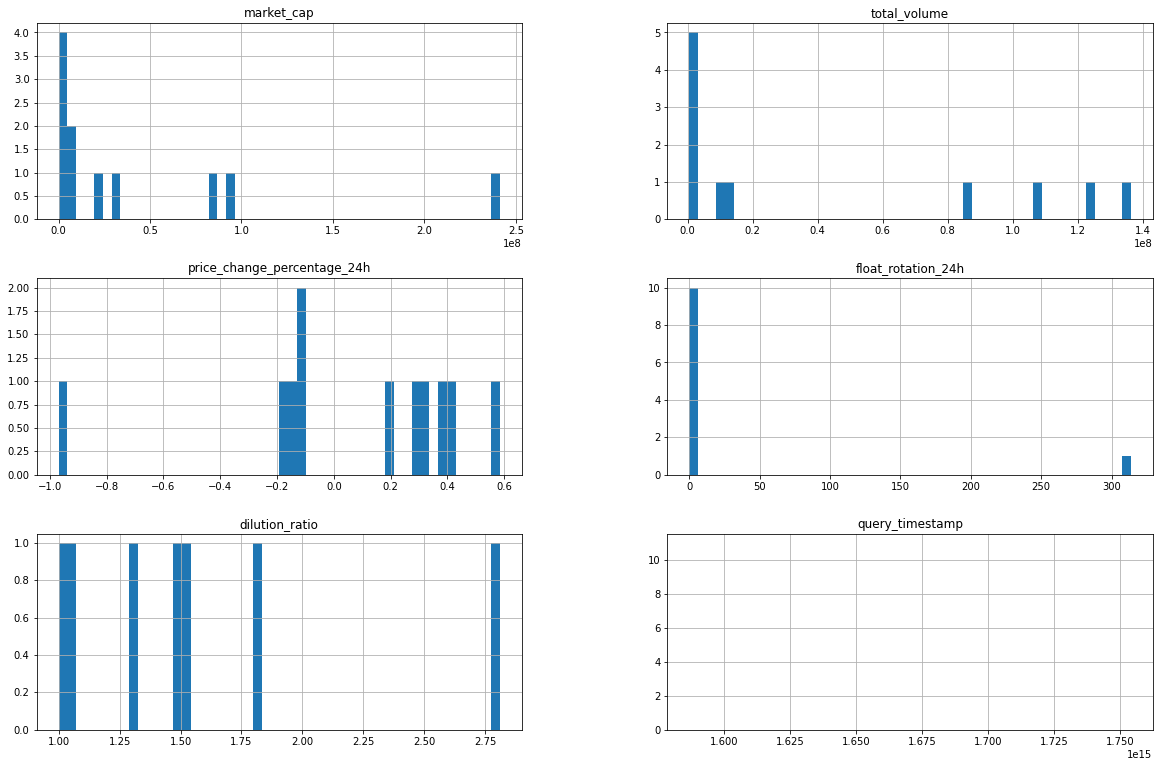

In [45]:
df_main.hist(bins = 50,figsize = (20,13))

In [46]:
from talib.abstract import *

cg = CoinGeckoAPI()
frames = []

try:
  
  for i in tqdm(List):

    a = cg.get_coin_ohlc_by_id(id=i, vs_currency='usd', days = '7')

    df = pd.DataFrame(data=a, columns = ['date','open','high', 'low', 'close'])

    df['datetime'] = pd.to_datetime(df['date'], unit='ms')
    df['id'] = str(i)
    
    df['sma10'] = SMA(df, timeperiod=10,price='close') # calculate on close prices by default

    df['sma20'] = SMA(df, timeperiod=20,price='close') # calculate on close prices by default
    df['sma50'] = SMA(df, timeperiod=50,price='close') # calculate on close prices by default
    df['sma100'] = SMA(df, timeperiod=100,price='close') # calculate on close prices by default
    df['sma200'] = SMA(df, timeperiod=200,price='close') # calculate on close prices by default
    df['atr'] = ATR(df, timeperiod=20) # calculate on close prices by default

    trace1 = {
    'x': df.datetime,
    'open': df.open,
    'close': df.close,
    'high': df.high,
    'low': df.low,
    'type': 'candlestick',
    'name': str(i).upper() ,
    'showlegend': True
    }


    trace2 = {
        'x': df.datetime,
        'y': df.sma10,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'yellow'
                },
        'name': 'SMA 10'
    }

    trace3 = {
        'x': df.datetime,
        'y': df.sma20,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'orange'
        },
        'name': 'SMA 20'
    }
    trace4 = {
        'x': df.datetime,
        'y': df.sma50,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'green'
                },
        'name': 'SMA 50'
    }

    trace5 = {
        'x': df.datetime,
        'y': df.sma100,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'blue'
        },
        'name': 'SMA 100'
    }
    trace6 = {
        'x': df.datetime,
        'y': df.sma200,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'purple'
        },
        'name': 'SMA 200'
    }

    data = [trace1, trace2, trace3,trace4,trace5,trace6]

    # Config graph layout
    layout = go.Layout({
        'title': {
            'text': str(i).upper().replace("-"," ") + ' Moving Averages',
            'font': {
                'size': 15
            }
        }
    })

              
      #CHARTING
    fig = go.Figure(data=data, layout=layout)
    fig.show()


    CoinGeckoAPI
    #time.sleep(60/50)
    frames.append(df)
    

except ConnectionError:
  time.sleep(60)

single = pd.concat(frames) #Careful, this line must be outside of the for loop


  0%|          | 0/11 [00:00<?, ?it/s]

In [47]:
single.tail()


,date,open,high,low,close,datetime,id,sma10,sma20,sma50,sma100,sma200,atr
38,1670313600000,0.288550,0.288727,0.287491,0.288284,2022-12-06 08:00:00,tokocrypto,0.297881,0.296352,NaN,NaN,NaN,0.007273
39,1670328000000,0.289499,0.289499,0.285572,0.285572,2022-12-06 12:00:00,tokocrypto,0.297357,0.295652,NaN,NaN,NaN,0.007105
40,1670342400000,0.285104,0.511908,0.285104,0.466367,2022-12-06 16:00:00,tokocrypto,0.314125,0.303922,NaN,NaN,NaN,0.018090
41,1670356800000,0.465183,0.465183,0.432830,0.432830,2022-12-06 20:00:00,tokocrypto,0.326817,0.310810,NaN,NaN,NaN,0.018863
42,1670371200000,0.429737,0.429737,0.410103,0.410103,2022-12-07 00:00:00,tokocrypto,0.336933,0.316226,NaN,NaN,NaN,0.019056


In [48]:
proprietary_screener = "proprietary_screener_ohlc"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

ohlc = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

ohlc

,date,open,high,low,close,datetime,id,sma10,sma20,sma50,sma100,sma200,atr
0,1670371200000,0.133070,0.134370,0.133070,0.134370,2022-12-07 00:00:00,cartesi,0.121034,0.115856,None,None,None,0.002543
1,1670371200000,0.095029,0.095306,0.095029,0.095306,2022-12-07 00:00:00,cortex,0.099150,0.094640,None,None,None,0.002546
2,1670371200000,0.001122,0.001204,0.001122,0.001204,2022-12-07 00:00:00,earthfund,0.000997,0.000957,None,None,None,0.000045
3,1670371200000,0.581201,0.581201,0.552599,0.552599,2022-12-07 00:00:00,fable-of-the-dragon,0.631406,0.697064,None,None,None,0.079318
4,1670371200000,0.000059,0.000059,0.000053,0.000053,2022-12-07 00:00:00,nucleus-vision,0.000060,0.000049,None,None,None,0.000009
5,1670371200000,14.900000,15.400000,14.900000,15.400000,2022-12-07 00:00:00,numeraire,16.276000,13.941500,None,None,None,0.706784
6,1670371200000,1.090000,1.130000,1.090000,1.130000,2022-12-07 00:00:00,offshift,0.926527,0.728291,None,None,None,0.049215
7,1670371200000,0.000500,0.000500,0.000500,0.000500,2022-12-07 00:00:00,omax-token,0.000437,0.000394,None,None,None,0.000026
8,1670371200000,0.000531,0.000540,0.000531,0.000540,2022-12-07 00:00:00,option-room,0.007024,0.011912,None,None,None,0.000864
9,1670371200000,1.250000,1.250000,1.250000,1.250000,2022-12-07 00:00:00,sushi,1.353000,1.350500,None,None,None,0.027697


In [49]:
#@title Other Historical { display-mode: "code" }
from talib.abstract import *
import pandas as pd
import numpy as np

cg = CoinGeckoAPI()

frames = []


try:

  for i in tqdm(List):

    a = cg.get_coin_market_chart_by_id(id=i, vs_currency='usd', days = 'max')

    b = a['prices']
    df1 = pd.DataFrame(b, columns = ['date','price'])
    df1['datetime'] = pd.to_datetime(df1['date'], unit='ms')
    df1.set_index("date", inplace = True)

    c = a['market_caps']
    df2 = pd.DataFrame(c, columns = ['date','market_cap'])
    df2.set_index("date", inplace = True)

    d = a['total_volumes']
    df3 = pd.DataFrame(d, columns = ['date','volume'])   
    df3.set_index("date", inplace = True)

    result = pd.concat([df1, df2,df3], ignore_index=False,axis=1)

    result['id'] = i
    result['stdev_30d'] = result['price'].rolling(30).std()
    result['volume_30d'] = result['volume'].rolling(30).mean()
    result['rel_volume'] = result['volume'] / result['volume_30d'] 
    result['float_rotation'] = result['volume'] / result['market_cap'] 
    

    frames.append(result)
    time.sleep(60/50)
except ConnectionError:
    time.sleep(60)

single = pd.concat(frames) #Careful, this line must be outside of the for loop
single

  0%|          | 0/11 [00:00<?, ?it/s]

,price,datetime,market_cap,volume,id,stdev_30d,volume_30d,rel_volume,float_rotation
date,,,,,,,,,
1587686400000,0.056747,2020-04-24 00:00:00,0.000000e+00,9.182619e+07,cartesi,NaN,NaN,NaN,inf
1587772800000,0.052221,2020-04-25 00:00:00,0.000000e+00,1.868364e+07,cartesi,NaN,NaN,NaN,inf
1587859200000,0.051742,2020-04-26 00:00:00,0.000000e+00,8.643384e+06,cartesi,NaN,NaN,NaN,inf
1587945600000,0.046390,2020-04-27 00:00:00,0.000000e+00,1.162434e+07,cartesi,NaN,NaN,NaN,inf
1588032000000,0.041803,2020-04-28 00:00:00,0.000000e+00,1.492185e+07,cartesi,NaN,NaN,NaN,inf
...,...,...,...,...,...,...,...,...,...
1670025600000,0.304615,2022-12-03 00:00:00,2.283852e+07,7.332814e+06,tokocrypto,0.037651,7.379865e+06,0.993624,0.321072
1670112000000,0.288765,2022-12-04 00:00:00,2.173143e+07,2.609789e+06,tokocrypto,0.039071,7.415565e+06,0.351934,0.120093
1670198400000,0.299750,2022-12-05 00:00:00,2.251114e+07,2.310668e+06,tokocrypto,0.040799,7.422837e+06,0.311292,0.102646


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74551b1f10>,
      dtype=object)

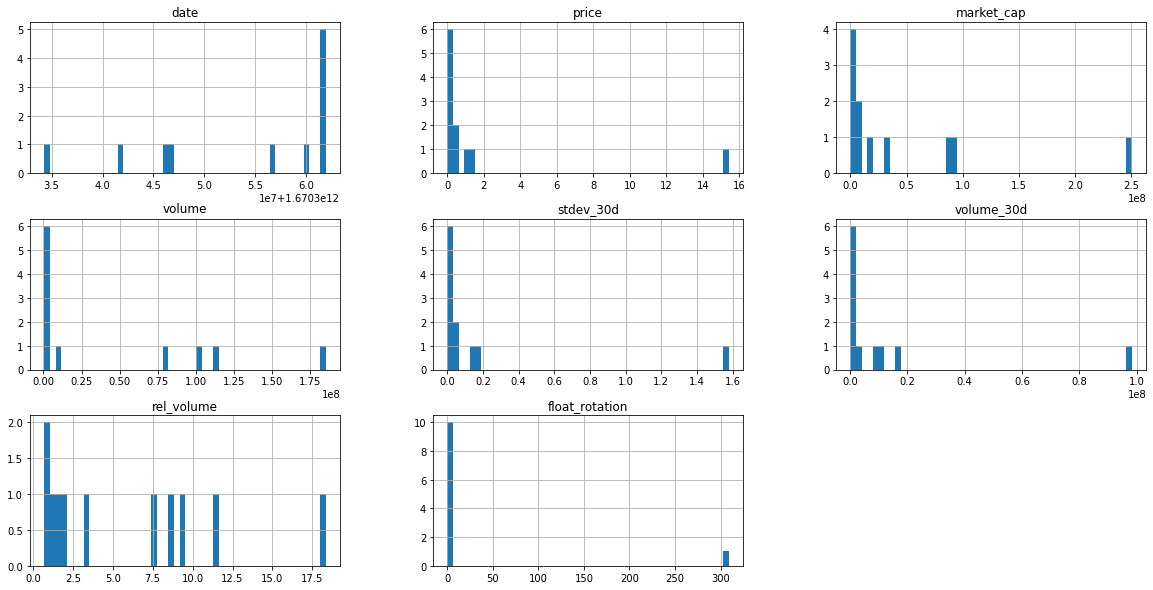

In [50]:
from numpy.lib.twodim_base import histogram2d

proprietary_screener = "proprietary_screener_hist"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=True) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost. WHERE datetime CONTAINS '2021'

hist = pd.read_sql("""
select 
*
from {}  

Group by id


""".format(proprietary_screener), conn_SQLite)

hist.hist(bins = 50,figsize = (20, 10))

In [51]:
#df =  base.join(ohlc)

df1 = df_main.merge(hist, on='id', how='left')
df2 = df1.merge(ohlc, on='id', how='right')

df2 = df2.drop(
                ['date_x', 'datetime_x', 'market_cap_y',
                'open', 'high','volume','close','datetime_y',
                'date_y', 'low', 'market_cap_y',
                 'float_rotation', 'low', 'volume_30d','total_volume']
                 ,axis=1)

df2 = df2.rename(columns = {'market_cap_x':'market_cap', 'query_date_x':'query_date',"last_updated":"vendor_last_update"})
   

df2

,id,symbol,name,market_cap,price_change_percentage_24h,float_rotation_24h,dilution_ratio,vendor_last_update,watchlist_name,query_date,...,note_research,price,stdev_30d,rel_volume,sma10,sma20,sma50,sma100,sma200,atr
0,cartesi,CTSI,Cartesi,8.659112e+07,0.197256,0.990327,1.539977,2022-12-06T20:30:01.688Z,Big Mover,2022-12-06,...,,0.132698,0.010785,8.798624,0.121034,0.115856,None,None,None,0.002543
1,cortex,CTXC,Cortex,1.948117e+07,-0.122577,0.551748,NaN,2022-12-06T20:30:23.872Z,Big Mover,2022-12-06,...,,0.095185,0.007782,3.470090,0.099150,0.094640,None,None,None,0.002546
2,earthfund,1EARTH,EarthFund,4.156410e+05,0.281688,1.369456,2.809178,2022-12-06T20:32:15.119Z,Big Mover,2022-12-06,...,,0.001263,0.000168,1.955690,0.000997,0.000957,None,None,None,0.000045
3,fable-of-the-dragon,TYRANT,Fable Of The Dragon,5.555900e+06,-0.160482,0.160452,1.000000,2022-12-06T20:31:08.513Z,Big Mover,2022-12-06,...,,0.531281,0.036289,0.832121,0.631406,0.697064,None,None,None,0.079318
4,nucleus-vision,NCASH,Nucleus Vision,1.639880e+05,0.305514,6.323042,NaN,2022-12-06T20:32:03.486Z,Big Mover,2022-12-06,...,,0.000059,0.000005,7.756743,0.000060,0.000049,None,None,None,0.000009
5,numeraire,NMR,Numeraire,9.252632e+07,-0.190447,1.329000,1.802227,2022-12-06T20:29:56.837Z,Big Mover,2022-12-06,...,,15.431763,1.580342,11.624144,16.276000,13.941500,None,None,None,0.706784
6,offshift,XFT,Offshift,7.513945e+06,0.584445,1.837941,1.501397,2022-12-06T20:30:57.590Z,Big Mover,2022-12-06,...,,1.075245,0.177909,0.716975,0.926527,0.728291,None,None,None,0.049215
7,omax-token,OMAX,Omax,4.809818e+06,0.391241,0.113823,1.042270,2022-12-06T20:31:19.550Z,Big Mover,2022-12-06,...,,0.000503,0.000085,1.576009,0.000437,0.000394,None,None,None,0.000026
8,option-room,ROOM,OptionRoom,6.558950e+03,-0.969213,313.430656,NaN,2022-12-06T20:33:23.538Z,Big Mover,2022-12-06,...,,0.000546,0.004880,18.359346,0.007024,0.011912,None,None,None,0.000864
9,sushi,SUSHI,Sushi,2.412419e+08,-0.099668,0.564855,1.296753,2022-12-06T20:29:47.559Z,Big Mover,2022-12-06,...,,1.307779,0.130462,1.141244,1.353000,1.350500,None,None,None,0.027697


Load Watchlist to Database

> Indented block



In [52]:
proprietary_screener = "proprietary_watchlist_hist"

df2.to_sql(proprietary_screener, conn_SQLite, if_exists='append', index=False) # writes to file
conn_SQLite.commit()
# Just be sure any changes have been committed or they will be lost. WHERE dateShows thee will

# Futures Coverage Indicator

In [53]:
#Query the derivatives table

# Group table By index ID and create a: where if the  contract type includes perpetual, at P Contract type Futures exist, at letter



In [54]:
#@title Gets Currencies { display-mode: "code" }
output = cg.get_supported_vs_currencies()
data = pd.DataFrame(output, columns =['currencies'])
CoinGecko_currencies = "CoinGecko_currencies"



data.to_sql(CoinGecko_currencies, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_currencies = pd.read_sql('select * from {}'.format(CoinGecko_currencies), conn_SQLite)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f744bea6280>,
      dtype=object)

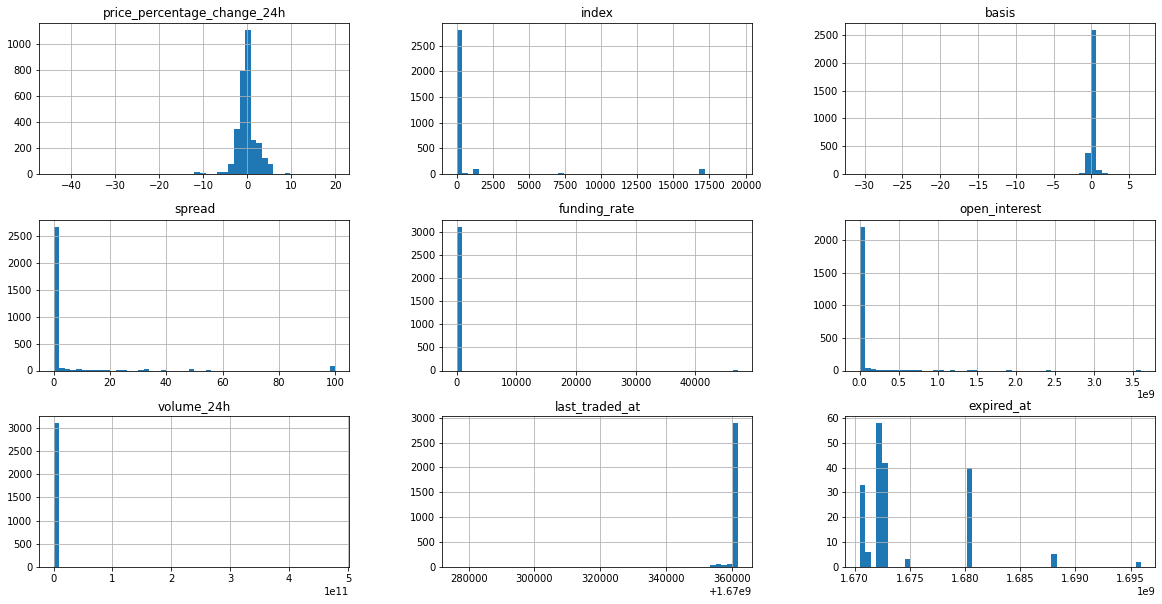

In [55]:
#@title
output = cg.get_derivatives()
data = pd.json_normalize(output,max_level=4)
data.hist(bins = 50,figsize = (20, 10))

In [56]:
#@title Get Global Data { display-mode: "code" }

output = cg.get_global()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

CoinGecko_global = "CoinGecko_global"

data.to_sql(CoinGecko_global, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_global = pd.read_sql('select * from {}'.format(CoinGecko_global), conn_SQLite)
CoinGecko_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   active_cryptocurrencies               67 non-null     int64  
 1   upcoming_icos                         67 non-null     int64  
 2   ongoing_icos                          67 non-null     int64  
 3   ended_icos                            67 non-null     int64  
 4   markets                               67 non-null     int64  
 5   total_market_cap                      61 non-null     float64
 6   total_volume                          61 non-null     float64
 7   market_cap_percentage                 10 non-null     float64
 8   market_cap_change_percentage_24h_usd  67 non-null     float64
 9   updated_at                            67 non-null     int64  
dtypes: float64(4), int64(6)
memory usage: 5.4 KB


In [57]:
#@title Get Assess platforms { display-mode: "code" }

output = cg.get_asset_platforms()

data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)



CoinGecko_asset_platforms = "CoinGecko_asset_platforms"

data.to_sql(CoinGecko_asset_platforms, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_asset_platforms = pd.read_sql('select * from {}'.format(CoinGecko_asset_platforms), conn_SQLite)
CoinGecko_asset_platforms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                130 non-null    object 
 1   chain_identifier  41 non-null     float64
 2   name              130 non-null    object 
 3   shortname         130 non-null    object 
dtypes: float64(1), object(3)
memory usage: 4.2+ KB


**bold text**# Create Features

In [58]:
#@title
# Just be sure any changes have been committed or they will be lost.
conn_SQLite.close()

# Backtesting

# Chartbook
